In [1]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.covariance import LedoitWolf, EmpiricalCovariance, ShrunkCovariance, OAS, GraphLassoCV, MinCovDet, GraphLasso
import matplotlib.pyplot as plt
import pyfolio as pf
import seaborn as sns
%matplotlib inline

# 1) Generate correlated data

In [2]:
def generateData(nObs, size0, size1, sigma1):
    # Time series of correlated variables
    #1) generating some uncorrelated data
    np.random.seed(seed=12345)
    random.seed(12345)
    x = np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols = [random.randint(0, size0-1) for i in xrange(size1)]
    y = x[:, cols] + np.random.normal(0, sigma1, size=(nObs, len(cols)))
    x = np.append(x, y, axis=1)
    x = pd.DataFrame(x, columns=range(1, x.shape[1] + 1))
    return x, cols

In [3]:
nObs,size0,size1,sigma1 = 10000,3,3,.25
x, cols = generateData(nObs, size0, size1, sigma1)

In [4]:
print [(j+1,size0+i) for i,j in enumerate(cols,1)]

[(2, 4), (1, 5), (3, 6)]


In [5]:
x.tail()

,1,2,3,4,5,6
9995,0.625796,0.963985,-0.319381,1.069436,0.978322,-0.412286
9996,-1.753015,-0.823751,0.097032,-1.580930,-1.435213,-0.020367
9997,0.424680,0.482148,-0.576479,0.469690,0.483510,-0.683022
9998,-0.515959,-1.581962,-1.392378,-1.489677,-0.857145,-1.468738
9999,-0.742135,-0.938589,0.039196,-0.938786,-0.734818,0.069608


# 2) compute and plot correl matrix

In [6]:
def plotCorrMatrix(path, corr, labels=None):
    # Heatmap of the correlation matrix
    if labels is None:
        labels = []
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0] + .5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0] + .5),labels)
    mpl.savefig(path)
#     mpl.clf();
    mpl.show()
#     mpl.close() # reset pylab
    return

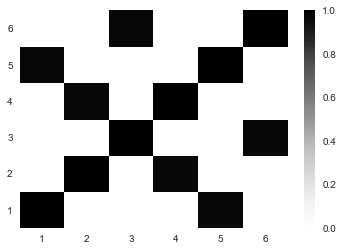

In [7]:
cov, corr = x.cov(), x.corr()
plotCorrMatrix('HRP3_corr0.png', corr, labels=corr.columns)

In [8]:
 # 风险预算优化
def calculate_portfolio_var(w, V):
    # 计算组合风险的函数
    w = np.matrix(w)
    return (w * V * w.T)[0, 0]

In [9]:
def calculate_risk_contribution(w ,V):
    # 计算单个资产对总体风险贡献度的函数
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w, V))
    # 边际风险贡献
    MRC = V * w.T
    # 风险贡献
    RC = np.multiply(MRC, w.T) / sigma
    return RC

# 3) cluster

In [10]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=((1 - corr) / 2.) ** .5 # distance matrix
    return dist

In [11]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1,0],link[-1,1]])
    numItems = link[-1,3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0]*2, 2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index;
        j = df0.values - numItems
        sortIx[i] = link[j,0] # item 1
        df0 = pd.Series(link[j,1], index=i+1)
        sortIx = sortIx.append(df0) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

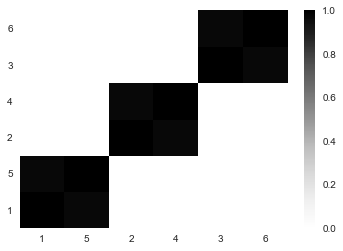

In [12]:
dist = correlDist(corr)
link = sch.linkage(dist,'single')
sortIx = getQuasiDiag(link)
sortIx = corr.index[sortIx].tolist() # recover labels
df0 = corr.loc[sortIx,sortIx] # reorder
plotCorrMatrix('HRP3_corr1.png', df0, labels=df0.columns)

# 4) Capital allocation

In [13]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [14]:
def getClusterVar(cov, cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems, cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return cVar

In [15]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j, k in ((0,len(i)/2), \
            (len(i) / 2, len(i))) if len(i) > 1] # bi-section
        for i in xrange(0, len(cItems), 2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i + 1] # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w

In [16]:
cov

,1,2,3,4,5,6
1,0.999842,0.001719,0.000391,-0.000464,1.001938,0.002145
2,0.001719,1.010733,0.002636,1.005718,0.001881,0.005384
3,0.000391,0.002636,0.996825,0.002417,0.000751,0.993865
4,-0.000464,1.005718,0.002417,1.064009,0.000368,0.004524
5,1.001938,0.001881,0.000751,0.000368,1.065588,0.002898
6,0.002145,0.005384,0.993865,0.004524,0.002898,1.054265


In [154]:
sortIx

[1, 5, 2, 4, 3, 6]

In [159]:
hrp = getRecBipart(cov,sortIx)

In [160]:
hrp

1    0.172779
5    0.161826
2    0.170609
4    0.240818
3    0.130540
6    0.123428
dtype: float64

In [162]:
calculate_risk_contribution(hrp, cov.as_matrix())

matrix([[ 0.08906017],
        [ 0.11177391],
        [ 0.08501078],
        [ 0.17144021],
        [ 0.06929105],
        [ 0.06327731]])

# 真实数据

In [17]:
def metric(daily_ret):
    an_ret = pf.empyrical.annual_return(daily_ret)
    sharpe = pf.empyrical.sharpe_ratio(daily_ret)
    vol = pf.empyrical.annual_volatility(daily_ret)
    maxdraw = pf.empyrical.max_drawdown(daily_ret)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

In [18]:
DATA_DIR = 'C:/Users/jgtzsx01/Documents/workspace/zjsxzy_in_js/Research/data/'

In [19]:
fname = '%s/assets.xlsx'%(DATA_DIR)

In [20]:
df = pd.read_excel(fname, index_col=0)

In [21]:
df = df[['881001.WI', 'HSI.HI', 'SPX.GI', '065.CS', 'AU9999.SGE','B.IPE']]

In [22]:
df = df[df['B.IPE'] > 0]

In [24]:
df = df[df.index >= '2012-01-01']

In [25]:
ret_df = df.pct_change().dropna()

In [26]:
ret_df.cov()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE
881001.WI,3.120104e-04,9.224364e-05,2.126449e-05,3.423597e-07,4.808954e-06,2.528905e-05
HSI.HI,9.224364e-05,1.136497e-04,2.132952e-05,3.164886e-08,4.921283e-06,2.633752e-05
SPX.GI,2.126449e-05,2.132952e-05,6.192594e-05,8.399489e-08,3.773013e-07,5.131565e-05
065.CS,3.423597e-07,3.164886e-08,8.399489e-08,7.366284e-07,5.903019e-08,-5.302305e-07
AU9999.SGE,4.808954e-06,4.921283e-06,3.773013e-07,5.903019e-08,8.492159e-05,-8.512067e-07
B.IPE,2.528905e-05,2.633752e-05,5.131565e-05,-5.302305e-07,-8.512067e-07,3.694904e-04


In [27]:
wb = getRecBipart(ret_df[-25:].cov() * 100000, df.columns)

In [28]:
wb

881001.WI     0.008783
HSI.HI        0.007072
SPX.GI        0.015387
065.CS        0.943577
AU9999.SGE    0.023296
B.IPE         0.001885
dtype: float64

In [29]:
calculate_risk_contribution(wb, (ret_df.cov()*10000).as_matrix())

matrix([[ 0.00416047],
        [ 0.001703  ],
        [ 0.00255873],
        [ 0.07444747],
        [ 0.00555454],
        [ 0.00029201]])

In [30]:
new_df = df[(df.index >= ret_df.index[0]) & (df.index <= ret_df.index[-1])]

In [31]:
rebalance_dates = set(new_df.resample('BM').last().index)

In [32]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
wb = np.array([0, 0, 0, 0, 0, 0])
for date in new_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        his_ret = ret_df[ret_df.index <= date]
        if his_ret.shape[0] >= 60:
            cov = his_ret[-60:].cov()
            wb = getRecBipart(cov, df.columns)
            wb = np.array(wb)

In [33]:
weight.tail()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE
2017-07-03,0.0103025,0.0137807,0.0231386,0.930004,0.0206814,0.0020926
2017-07-04,0.0103025,0.0137807,0.0231386,0.930004,0.0206814,0.0020926
2017-07-05,0.0103025,0.0137807,0.0231386,0.930004,0.0206814,0.0020926
2017-07-06,0.0103025,0.0137807,0.0231386,0.930004,0.0206814,0.0020926
2017-07-07,0.0103025,0.0137807,0.0231386,0.930004,0.0206814,0.0020926


In [34]:
hrp_portfolio_ret = (weight * ret_df).sum(axis=1)

In [35]:
metric(hrp_portfolio_ret)

Annual return: 4.05%
Sharpe ratio: 2.96
Annual volatility: 1.34%
Max drawdown: -3.26%


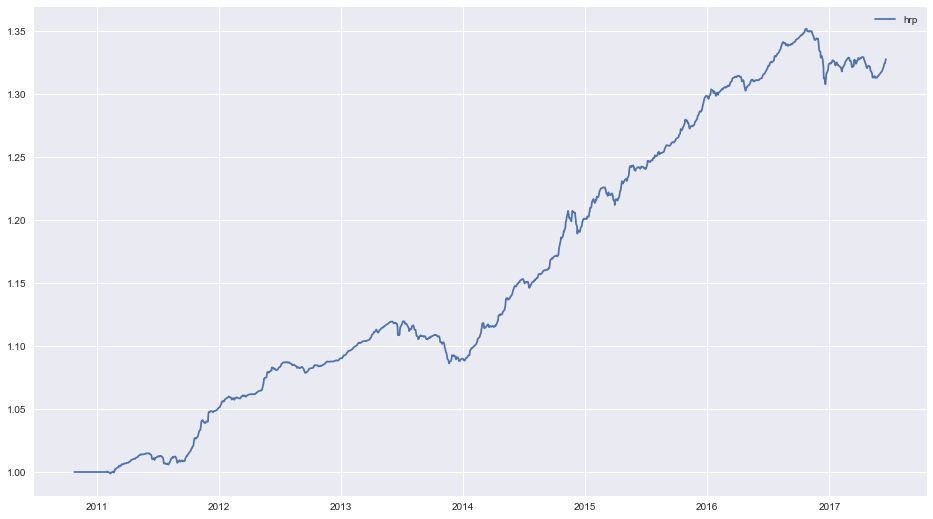

In [180]:
plt.figure(figsize=(16, 9))
plt.plot((1+hrp_portfolio_ret).cumprod(), label='hrp')
# plt.plot((1+ret_df['881001.WI']).cumprod(), label='881001.WI')
# plt.plot((1+ret_df['HSI.HI']).cumprod(), label='HSI.HI')
# plt.plot((1+ret_df['SPX.GI']).cumprod(), label='SPX.GI')
# plt.plot((1+ret_df['065.CS']).cumprod(), label='065.CS')
# plt.plot((1+ret_df['AU9999.SGE']).cumprod(), label='AU9999.SGE')
# plt.plot((1+ret_df['B.IPE']).cumprod(), label='B.IPE')
plt.legend()

# 枚举回溯天数

In [223]:
ks = range(5, 30, 5)

In [ ]:
result = {}

In [224]:
for k in ks:
    print k
    weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
    wb = np.array([0, 0, 0, 0, 0, 0])
    for date in new_df.index:
        weight.loc[date] = wb
        if date in rebalance_dates:
            his_ret = ret_df[ret_df.index <= date]
            if his_ret.shape[0] >= k:
                cov = his_ret[-k:].cov()
                wb = getRecBipart(cov, df.columns)
                wb = np.array(wb)
    hrp_portfolio_ret = (weight * ret_df).sum(axis=1)
    result[k] = hrp_portfolio_ret

5
10
15
20
25


In [229]:
metric_df = pd.DataFrame(columns=['sharpe', 'annual ret', 'annual vol', 'max drawdown'], index=result.keys())
for k, v in result.iteritems():
    sharpe, annual_ret = pf.empyrical.sharpe_ratio(v[v!=0]), pf.empyrical.annual_return(v[v!=0])
    annual_vol, max_drawdown = pf.empyrical.annual_volatility(v[v!=0]), pf.empyrical.max_drawdown(v[v!=0])
    metric_df.loc[k, 'sharpe'] = sharpe
    metric_df.loc[k, 'annual ret'] = annual_ret
    metric_df.loc[k, 'annual vol'] = annual_vol
    metric_df.loc[k, 'max drawdown'] = max_drawdown

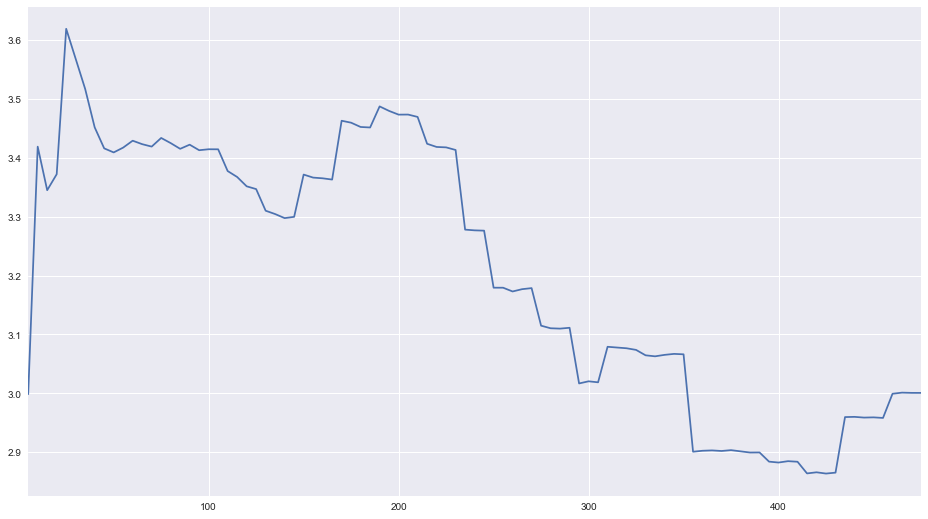

In [234]:
plt.figure(figsize=(16, 9))
metric_df['sharpe'].plot()

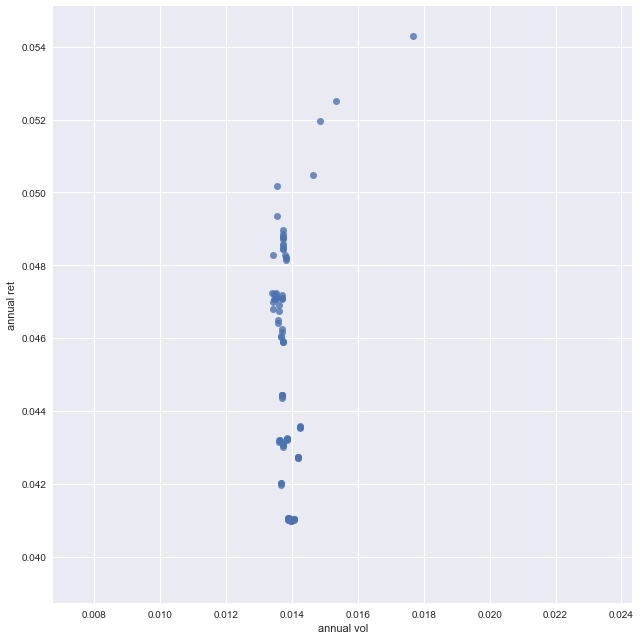

In [255]:
sns.lmplot(x='annual vol', y='annual ret', data=metric_df, fit_reg=False, size=9)

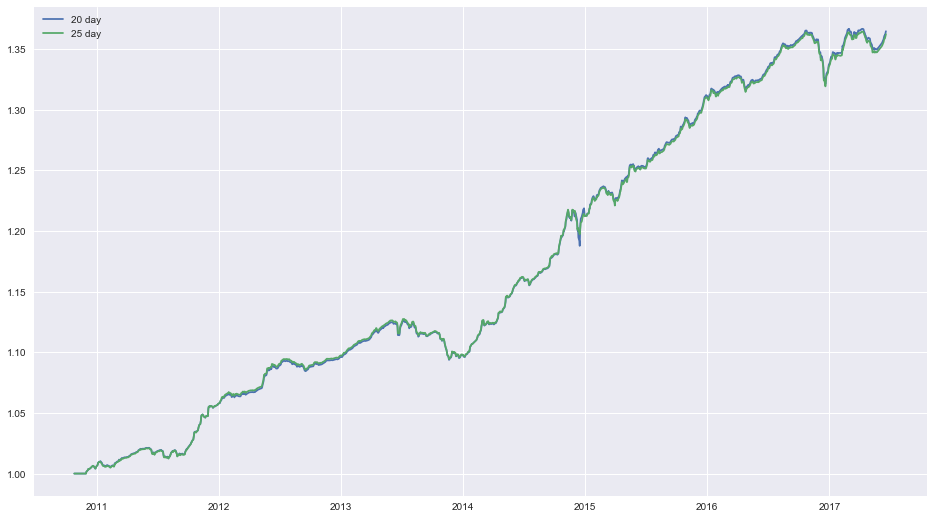

In [254]:
plt.figure(figsize=(16, 9))
plt.plot((1+result[20]).cumprod(), label='20 day')
plt.plot((1+result[25]).cumprod(), label='25 day')
plt.legend()

In [257]:
metric(result[20])

Annual return: 4.96%
Sharpe ratio: 3.34
Annual volatility: 1.45%
Max drawdown: -3.24%


# 其他估计协方差的方法

## Ledoit-Wolf shrinkage

In [118]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
wb = np.array([0, 0, 0, 0, 0, 0])
lw = LedoitWolf()
for date in new_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        X_train = ret_df[ret_df.index <= date]
        lw.fit(X_train)
        cov = pd.DataFrame(lw.covariance_, columns=df.columns, index=df.columns)
        wb = getRecBipart(cov, df.columns)
        wb = np.array(wb)

In [119]:
weight.tail()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE
2017-06-13,0.00788038,0.0138609,0.0211627,0.921117,0.028309,0.0076699
2017-06-14,0.00788038,0.0138609,0.0211627,0.921117,0.028309,0.0076699
2017-06-15,0.00788038,0.0138609,0.0211627,0.921117,0.028309,0.0076699
2017-06-16,0.00788038,0.0138609,0.0211627,0.921117,0.028309,0.0076699
2017-06-19,0.00788038,0.0138609,0.0211627,0.921117,0.028309,0.0076699


In [91]:
lw_portfolio_ret = (weight * ret_df).sum(axis=1)

In [92]:
metric(lw_portfolio_ret)

Annual return: 4.62%
Sharpe ratio: 1.77
Annual volatility: 2.57%
Max drawdown: -4.23%


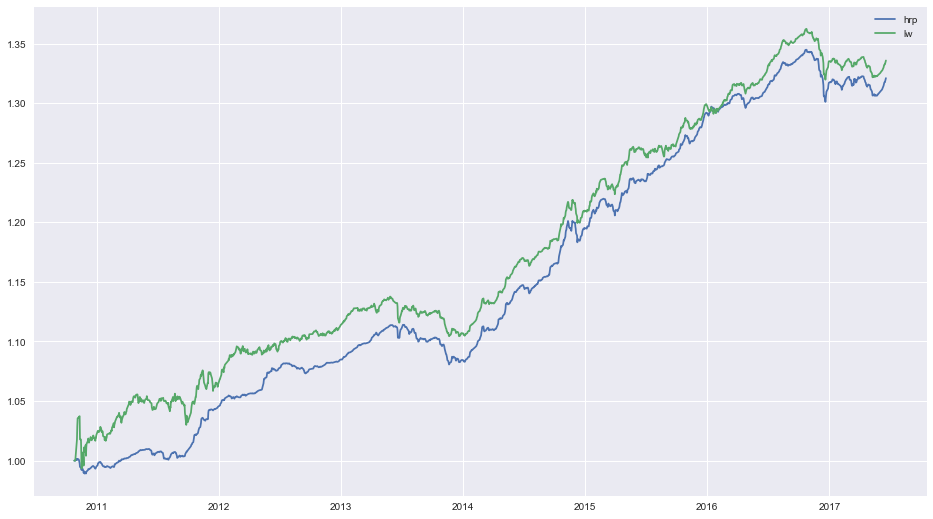

In [93]:
plt.figure(figsize=(16, 9))
plt.plot((1+hrp_portfolio_ret).cumprod(), label='hrp')
plt.plot((1+lw_portfolio_ret).cumprod(), label='lw')
# plt.plot((1+ret_df['881001.WI']).cumprod(), label='881001.WI')
# plt.plot((1+ret_df['HSI.HI']).cumprod(), label='HSI.HI')
# plt.plot((1+ret_df['SPX.GI']).cumprod(), label='SPX.GI')
# plt.plot((1+ret_df['065.CS']).cumprod(), label='065.CS')
# plt.plot((1+ret_df['AU9999.SGE']).cumprod(), label='AU9999.SGE')
# plt.plot((1+ret_df['B.IPE']).cumprod(), label='B.IPE')
plt.legend()

## Shrunk Covariance

In [131]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
wb = np.array([0, 0, 0, 0, 0, 0])
sc = ShrunkCovariance()
for date in new_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        X_train = ret_df[ret_df.index <= date]
        sc.fit(X_train)
        cov = pd.DataFrame(sc.covariance_, columns=df.columns, index=df.columns)
        wb = getRecBipart(cov, df.columns)
        wb = np.array(wb)

In [132]:
weight.tail()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE
2017-06-13,0.0336534,0.0571749,0.0827739,0.68386,0.109613,0.032925
2017-06-14,0.0336534,0.0571749,0.0827739,0.68386,0.109613,0.032925
2017-06-15,0.0336534,0.0571749,0.0827739,0.68386,0.109613,0.032925
2017-06-16,0.0336534,0.0571749,0.0827739,0.68386,0.109613,0.032925
2017-06-19,0.0336534,0.0571749,0.0827739,0.68386,0.109613,0.032925


In [133]:
sc_portfolio_ret = (weight * ret_df).sum(axis=1)

In [134]:
metric(sc_portfolio_ret)

Annual return: 4.62%
Sharpe ratio: 1.34
Annual volatility: 3.40%
Max drawdown: -4.75%


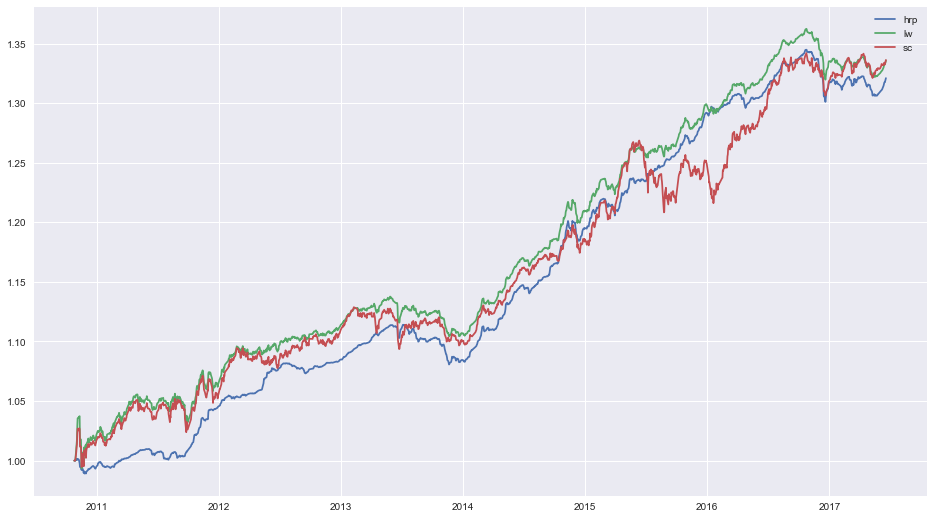

In [135]:
plt.figure(figsize=(16, 9))
plt.plot((1+hrp_portfolio_ret).cumprod(), label='hrp')
plt.plot((1+lw_portfolio_ret).cumprod(), label='lw')
plt.plot((1+sc_portfolio_ret).cumprod(), label='sc')
# plt.plot((1+ret_df['881001.WI']).cumprod(), label='881001.WI')
# plt.plot((1+ret_df['HSI.HI']).cumprod(), label='HSI.HI')
# plt.plot((1+ret_df['SPX.GI']).cumprod(), label='SPX.GI')
# plt.plot((1+ret_df['065.CS']).cumprod(), label='065.CS')
# plt.plot((1+ret_df['AU9999.SGE']).cumprod(), label='AU9999.SGE')
# plt.plot((1+ret_df['B.IPE']).cumprod(), label='B.IPE')
plt.legend()

## Oracle Approximating Shrinkage

In [136]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
wb = np.array([0, 0, 0, 0, 0, 0])
oas = OAS()
for date in new_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        X_train = ret_df[ret_df.index <= date]
        oas.fit(X_train)
        cov = pd.DataFrame(oas.covariance_, columns=df.columns, index=df.columns)
        wb = getRecBipart(cov, df.columns)
        wb = np.array(wb)

In [142]:
weight.tail()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE
2017-06-13,0.00445643,0.00786479,0.0120756,0.955101,0.0161672,0.00433495
2017-06-14,0.00445643,0.00786479,0.0120756,0.955101,0.0161672,0.00433495
2017-06-15,0.00445643,0.00786479,0.0120756,0.955101,0.0161672,0.00433495
2017-06-16,0.00445643,0.00786479,0.0120756,0.955101,0.0161672,0.00433495
2017-06-19,0.00445643,0.00786479,0.0120756,0.955101,0.0161672,0.00433495


In [137]:
oas_portfolio_ret = (weight * ret_df).sum(axis=1)

In [138]:
metric(oas_portfolio_ret)

Annual return: 4.69%
Sharpe ratio: 1.99
Annual volatility: 2.32%
Max drawdown: -4.62%


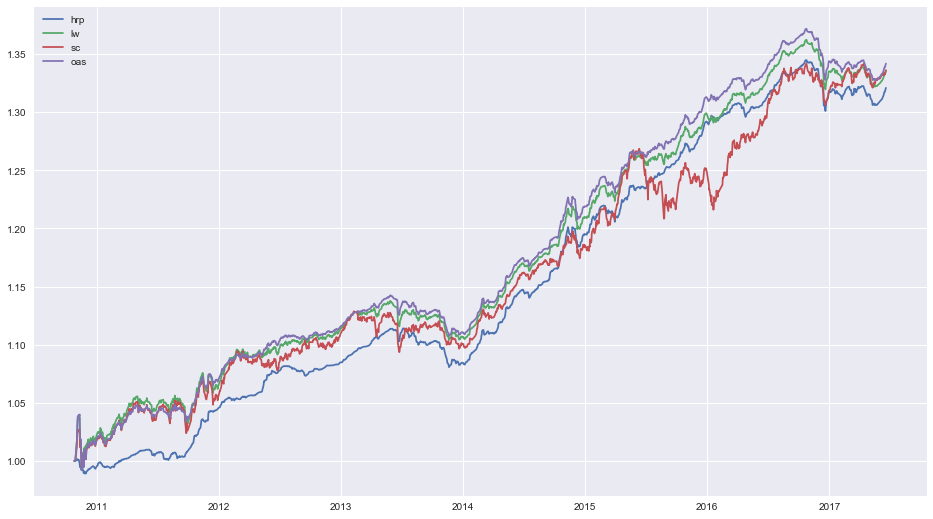

In [139]:
plt.figure(figsize=(16, 9))
plt.plot((1+hrp_portfolio_ret).cumprod(), label='hrp')
plt.plot((1+lw_portfolio_ret).cumprod(), label='lw')
plt.plot((1+sc_portfolio_ret).cumprod(), label='sc')
plt.plot((1+oas_portfolio_ret).cumprod(), label='oas')
# plt.plot((1+ret_df['881001.WI']).cumprod(), label='881001.WI')
# plt.plot((1+ret_df['HSI.HI']).cumprod(), label='HSI.HI')
# plt.plot((1+ret_df['SPX.GI']).cumprod(), label='SPX.GI')
# plt.plot((1+ret_df['065.CS']).cumprod(), label='065.CS')
# plt.plot((1+ret_df['AU9999.SGE']).cumprod(), label='AU9999.SGE')
# plt.plot((1+ret_df['B.IPE']).cumprod(), label='B.IPE')
plt.legend()